<a href="https://www.kaggle.com/code/sreenihaar/maincode?scriptVersionId=236461138" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, GlobalMaxPooling1D
from tensorflow.keras.layers import Dense, Dropout, Concatenate, MultiHeadAttention, Add, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import pickle
from nltk.sentiment import SentimentIntensityAnalyzer
import textstat

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('punkt_tab')

2025-04-27 17:18:48.088275: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745774328.338462      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745774328.438119      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/n

True

In [3]:
# Load original datasets
# data_path = r'C:\Users\AI-Team\Downloads\fake_news\fake_news_prediction'
data_path='/kaggle/input/dataset/fake_news_prediction'
true_df = pd.read_csv(f'{data_path}/Data-1/True.csv')
fake_df = pd.read_csv(f'{data_path}/Data-1/Fake.csv')

# Assign labels
true_df['label'] = 1  # Real news
fake_df['label'] = 0  # Fake news

# Load new datasets
# new_data_path = r'C:\Users\AI-Team\Downloads\fake_news\newnews'
new_data_path = '/kaggle/input/dataset/newnews'
real1_df = pd.read_csv(f'{new_data_path}/real1.csv')
fake1_df = pd.read_csv(f'{new_data_path}/fake1.csv')

# Assign labels to new datasets
real1_df['label'] = 1  # Real news
fake1_df['label'] = 0  # Fake news

# Print column information to understand structure
print("Original true_df columns:", true_df.columns.tolist())
print("Original fake_df columns:", fake_df.columns.tolist())
print("New real1_df columns:", real1_df.columns.tolist())
print("New fake1_df columns:", fake1_df.columns.tolist())

Original true_df columns: ['title', 'text', 'subject', 'date', 'label']
Original fake_df columns: ['title', 'text', 'subject', 'date', 'label']
New real1_df columns: ['id', 'title', 'text', 'url', 'top_img', 'authors', 'source', 'publish_date', 'movies', 'images', 'canonical_link', 'meta_data', 'label']
New fake1_df columns: ['id', 'title', 'text', 'url', 'top_img', 'authors', 'source', 'publish_date', 'movies', 'images', 'canonical_link', 'meta_data', 'label']


In [4]:
# Function to clean and standardize dataframes
def clean_and_standardize(df):
    # Remove rows with missing title or text
    df = df.dropna(subset=['title', 'text'])

    # Basic text cleaning
    df['title'] = df['title'].str.strip()
    df['text'] = df['text'].str.strip()

    # Select only needed columns (match original dataset structure)
    needed_columns = ['title', 'text', 'label']
    existing_columns = [col for col in needed_columns if col in df.columns]

    return df[existing_columns]

# Clean and standardize all dataframes
true_df_clean = clean_and_standardize(true_df)
fake_df_clean = clean_and_standardize(fake_df)
real1_df_clean = clean_and_standardize(real1_df)
fake1_df_clean = clean_and_standardize(fake1_df)

# Combine all datasets
combined_df = pd.concat([true_df_clean, fake_df_clean, real1_df_clean, fake1_df_clean],
                         ignore_index=True)

# Check for duplicates (based on title and first 100 chars of text)
combined_df['text_start'] = combined_df['text'].str[:100]
combined_df = combined_df.drop_duplicates(subset=['title', 'text_start'])
combined_df = combined_df.drop(columns=['text_start'])


In [5]:
# Shuffle the dataset
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)
# Check class distribution
class_counts = combined_df['label'].value_counts()
print(f"Class distribution after combining all datasets: {class_counts}")

# Balance the dataset if needed
min_class_count = class_counts.min()
df_balanced = pd.DataFrame()
for label in combined_df['label'].unique():
    df_class = combined_df[combined_df['label'] == label]
    df_class = df_class.sample(min_class_count, random_state=42)
    df_balanced = pd.concat([df_balanced, df_class])
def clean_text(text):
    if pd.isna(text):
        return ""
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', ' URL ', text, flags=re.MULTILINE)
    # Replace numbers with 'NUM'
    text = re.sub(r'\d+', ' NUM ', text)
    # Remove special characters but keep punctuation for sentiment analysis
    text = re.sub(r'[^\w\s.,!?]', ' ', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text
final_df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
print(f"Final balanced dataset shape: {final_df.shape}")

# Add this line to define df
df = final_df.copy()

# Now this will work
df['content'] = df['title'].fillna('') + ' [SEP] ' + df['text'].fillna('')
df['content'] = df['content'].apply(clean_text)

# Save the combined dataset
output_folder_path='/kaggle/working'
final_df.to_csv(f'{output_folder_path}/combined_balanced_dataset.csv', index=False)


Class distribution after combining all datasets: label
1    21040
0    17989
Name: count, dtype: int64
Final balanced dataset shape: (35978, 3)


In [6]:
 # Basic statistics about the dataset
print("\nDataset Statistics:")
print(f"Number of articles: {len(final_df)}")
print(f"Average title length: {final_df['title'].str.len().mean():.2f} characters")
print(f"Average text length: {final_df['text'].str.len().mean():.2f} characters")
print(f"Number of real news: {len(final_df[final_df['label'] == 1])}")
print(f"Number of fake news: {len(final_df[final_df['label'] == 0])}")

# Sample a few entries from each class
print("\nSample of real news titles:")
print(final_df[final_df['label'] == 1]['title'].sample(3, random_state=42).tolist())
print("\nSample of fake news titles:")
print(final_df[final_df['label'] == 0]['title'].sample(3, random_state=42).tolist())


Dataset Statistics:
Number of articles: 35978
Average title length: 77.65 characters
Average text length: 2430.77 characters
Number of real news: 17989
Number of fake news: 17989

Sample of real news titles:
['Factbox: Fed and presidential campaign: where candidates stand', "Delrahim to be nominated to head U.S. Justice Department's Antitrust Division", 'Iran sticks to key limits of nuclear deal: U.N. watchdog report']

Sample of fake news titles:
['FINALLY! Fed Up Princeton Students Fight Back Against Black Lives Matter Terrorists’ Demands', 'WOW! WOMAN TOTALLY FREAKS OUT At Sight Of Confederate Flag In Store…REAL OR FAKE OUTRAGE? [Video]', 'PEDOPHILE PIGS Send Teenage Migrant Boys To Surgery After Out-Of-Control Rape In Refugee Camps [VIDEO]']


In [7]:
# Create a more informative content field
df['content'] = df['title'].fillna('') + ' [SEP] ' + df['text'].fillna('')
df['content'] = df['content'].apply(clean_text)

# Word Segmentation and Stop Word Removal
stop_words = set(stopwords.words('english'))

def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text)
    # Keep some important stopwords that might be relevant for fake news detection
    important_words = {'not', 'no', 'nor', 'but', 'however', 'although', 'though'}
    filtered_stop_words = stop_words - important_words
    tokens = [word for word in tokens if word not in filtered_stop_words]
    return ' '.join(tokens)

df['processed_content'] = df['content'].apply(tokenize_and_remove_stopwords)

# Feature Engineering - Add additional features
sia = SentimentIntensityAnalyzer()

In [8]:
import nltk


In [9]:
from nltk.tokenize import word_tokenize
word_tokenize("Hello, how are you?")


['Hello', ',', 'how', 'are', 'you', '?']

In [10]:
def extract_features(text):
    # Sentiment features
    sentiment = sia.polarity_scores(text)

    # Readability features
    readability = textstat.flesch_reading_ease(text)
    grade_level = textstat.flesch_kincaid_grade(text)

    # Text statistics
    word_count = len(text.split())
    avg_word_length = sum(len(word) for word in text.split()) / max(1, word_count)

    # Special character ratio
    special_char_count = len(re.findall(r'[.,!?;:]', text))
    special_char_ratio = special_char_count / max(1, len(text))

    # Create feature dictionary
    features = {
        'sentiment_pos': sentiment['pos'],
        'sentiment_neg': sentiment['neg'],
        'sentiment_neu': sentiment['neu'],
        'sentiment_compound': sentiment['compound'],
        'readability': readability,
        'grade_level': grade_level,
        'word_count': word_count,
        'avg_word_length': avg_word_length,
        'special_char_ratio': special_char_ratio
    }

    return features

# Extract additional features
features_df = pd.DataFrame(df['content'].apply(extract_features).tolist())
print(f"Additional features extracted: {features_df.columns.tolist()}")

Additional features extracted: ['sentiment_pos', 'sentiment_neg', 'sentiment_neu', 'sentiment_compound', 'readability', 'grade_level', 'word_count', 'avg_word_length', 'special_char_ratio']


In [11]:
# Tokenization with improved parameters
max_length = 300  # Reduced max sequence length
max_words = 15000  # Increased vocabulary size

# Initialize and fit tokenizer
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(df['processed_content'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['processed_content'])

# Pad sequences to a fixed length
X_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# TF-IDF Vectorization with improved parameters
tfidf_vectorizer = TfidfVectorizer(max_features=3000, min_df=2, max_df=0.85, ngram_range=(1, 2))
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_content']).toarray()

In [12]:
# Load GloVe Embeddings
def load_glove_embeddings(glove_path):
    embeddings_index = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# glove_path = r'C:\Users\AI-Team\Downloads\fake_news\glove.6B.300d.txt'
glove_path='/kaggle/input/glove-data/glove.6B/glove.6B.300d.txt'
glove_embeddings = load_glove_embeddings(glove_path)

embedding_dim = 300  # GloVe embedding dimension
vocab_size = min(max_words, len(tokenizer.word_index) + 1)
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i >= vocab_size:
        continue
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Create a feature matrix by combining TF-IDF and additional features
X_features = np.hstack((X_tfidf, features_df.values))
print(f"Combined feature matrix shape: {X_features.shape}")

# Labels
y = df['label'].values

Combined feature matrix shape: (35978, 3009)


In [13]:
# Define an improved model architecture
def build_improved_model(vocab_size, embedding_dim, max_length, feature_dim):
    # Input for sequences
    sequence_input = Input(shape=(max_length,), name='sequence_input')

    # Input for combined features
    feature_input = Input(shape=(feature_dim,), name='feature_input')

    # Embedding layer with GloVe
    embedding = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=False,
        name='embedding_layer'
    )(sequence_input)

    # Dropout after embedding (new)
    embedding_dropout = Dropout(0.3, name='embedding_dropout')(embedding)

    # SIMPLIFIED: Only TWO CNN branches instead of three
    # First CNN Branch with BatchNormalization
    conv1_branch1 = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same',
                          kernel_regularizer=l2(0.02), name='conv1_branch1')(embedding_dropout)
    bn1_branch1 = BatchNormalization(name='bn1_branch1')(conv1_branch1)
    pool1_branch1 = MaxPooling1D(pool_size=4, name='maxpool_branch1')(bn1_branch1)

    # Second CNN Branch with BatchNormalization
    conv1_branch2 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same',
                          kernel_regularizer=l2(0.02), name='conv1_branch2')(embedding_dropout)
    bn1_branch2 = BatchNormalization(name='bn1_branch2')(conv1_branch2)
    pool1_branch2 = MaxPooling1D(pool_size=4, name='maxpool_branch2')(bn1_branch2)

    # Concatenate the two branches
    concatenated = Concatenate(name='concatenation_layer')([pool1_branch1, pool1_branch2])
    dropout_after_concat = Dropout(0.4, name='dropout_after_concat')(concatenated)

    # Simpler Bi-LSTM Layer with fewer units
    bilstm = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.02)),
                          name='bi_lstm_layer')(dropout_after_concat)

    # Multi-head Attention Layer with fewer heads
    mha = MultiHeadAttention(
        num_heads=4,
        key_dim=16,
        name='multi_head_attention'
    )(bilstm, bilstm)

    # Add residual connection
    mha_layer = Add(name='residual_connection')([bilstm, mha])
    bn_after_mha = BatchNormalization(name='bn_after_mha')(mha_layer)

    # Global pooling
    global_pool = GlobalMaxPooling1D(name='global_pooling')(bn_after_mha)

    # Feature processing
    feature_dense = Dense(64, activation='relu', kernel_regularizer=l2(0.02), name='feature_dense')(feature_input)
    bn_feature = BatchNormalization(name='bn_feature')(feature_dense)

    # Combine sequence features with additional features
    combined = Concatenate(name='data_transfer')([global_pool, bn_feature])

    # Fully Connected Layers - Simplified
    dense1 = Dense(128, activation='relu', kernel_regularizer=l2(0.02), name='fully_connected_1')(combined)
    bn1 = BatchNormalization(name='bn_fc1')(dense1)
    dropout1 = Dropout(0.6, name='dropout1')(bn1)

    dense2 = Dense(64, activation='relu', kernel_regularizer=l2(0.02), name='fully_connected_2')(dropout1)
    bn2 = BatchNormalization(name='bn_fc2')(dense2)
    dropout2 = Dropout(0.6, name='dropout2')(bn2)

    # Output Layer - binary classification
    outputs = Dense(1, activation='sigmoid', name='output_layer')(dropout2)

    # Create and compile model
    model = Model(inputs=[sequence_input, feature_input], outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0005),  # Reduced learning rate
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def visualize_training_history(history, fold_num=None):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    title = 'Accuracy Curves'
    if fold_num:
        title += f' - Fold {fold_num}'
    ax1.set_title(title)
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.6)

    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    title = 'Loss Curves'
    if fold_num:
        title += f' - Fold {fold_num}'
    ax2.set_title(title)
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()

    if fold_num:
        plt.savefig(f'training_history_fold_{fold_num}.png', dpi=300, bbox_inches='tight')
    else:
        plt.savefig('training_history.png', dpi=300, bbox_inches='tight')

    plt.show()

def plot_additional_metrics(history, fold_num=None):
    if 'auc' in history.history and 'precision' in history.history and 'recall' in history.history:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

        # AUC plot
        ax1.plot(history.history['auc'], label='Training AUC')
        ax1.plot(history.history['val_auc'], label='Validation AUC')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('AUC')
        title = 'AUC Curves'
        if fold_num:
            title += f' - Fold {fold_num}'
        ax1.set_title(title)
        ax1.legend()
        ax1.grid(True, linestyle='--', alpha=0.6)

        # Precision plot
        ax2.plot(history.history['precision'], label='Training Precision')
        ax2.plot(history.history['val_precision'], label='Validation Precision')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Precision')
        title = 'Precision Curves'
        if fold_num:
            title += f' - Fold {fold_num}'
        ax2.set_title(title)
        ax2.legend()
        ax2.grid(True, linestyle='--', alpha=0.6)

        # Recall plot
        ax3.plot(history.history['recall'], label='Training Recall')
        ax3.plot(history.history['val_recall'], label='Validation Recall')
        ax3.set_xlabel('Epochs')
        ax3.set_ylabel('Recall')
        title = 'Recall Curves'
        if fold_num:
            title += f' - Fold {fold_num}'
        ax3.set_title(title)
        ax3.legend()
        ax3.grid(True, linestyle='--', alpha=0.6)

        plt.tight_layout()

        if fold_num:
            plt.savefig(f'additional_metrics_fold_{fold_num}.png', dpi=300, bbox_inches='tight')
        else:
            plt.savefig('additional_metrics.png', dpi=300, bbox_inches='tight')

        plt.show()

def plot_confusion_matrix(model, X_val_seq, X_val_features, y_val, fold_num=None):
    # Get predictions
    y_pred_proba = model.predict([X_val_seq, X_val_features])
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    # Calculate confusion matrix
    cm = confusion_matrix(y_val, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    title = 'Confusion Matrix'
    if fold_num:
        title += f' - Fold {fold_num}'
    plt.title(title)
    plt.xticks([0.5, 1.5], ['Fake (0)', 'Real (1)'])
    plt.yticks([0.5, 1.5], ['Fake (0)', 'Real (1)'])

    if fold_num:
        plt.savefig(f'confusion_matrix_fold_{fold_num}.png', dpi=300, bbox_inches='tight')
    else:
        plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')

    plt.show()

    # Print classification report
    print(classification_report(y_val, y_pred, target_names=['Fake News', 'Real News']))

def visualize_fold_results(fold_results):
    # Extract metrics
    folds = [result['fold'] for result in fold_results]
    accuracies = [result['val_accuracy'] for result in fold_results]
    aucs = [result['val_auc'] for result in fold_results]
    precisions = [result['val_precision'] for result in fold_results]
    recalls = [result['val_recall'] for result in fold_results]

    # Calculate F1 scores
    f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions, recalls)]

    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Accuracy
    axes[0, 0].bar(folds, accuracies, color='royalblue')
    axes[0, 0].set_title('Validation Accuracy by Fold')
    axes[0, 0].set_xlabel('Fold')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_ylim(0, 1)
    for i, acc in enumerate(accuracies):
        axes[0, 0].text(i+1, acc+0.02, f'{acc:.4f}', ha='center')

    # AUC
    axes[0, 1].bar(folds, aucs, color='orangered')
    axes[0, 1].set_title('Validation AUC by Fold')
    axes[0, 1].set_xlabel('Fold')
    axes[0, 1].set_ylabel('AUC')
    axes[0, 1].set_ylim(0, 1)
    for i, auc in enumerate(aucs):
        axes[0, 1].text(i+1, auc+0.02, f'{auc:.4f}', ha='center')

    # Precision & Recall
    axes[1, 0].bar(folds, precisions, color='green', label='Precision')
    axes[1, 0].bar(folds, recalls, color='purple', alpha=0.7, label='Recall')
    axes[1, 0].set_title('Precision & Recall by Fold')
    axes[1, 0].set_xlabel('Fold')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].set_ylim(0, 1)
    axes[1, 0].legend()

    # F1 Score
    axes[1, 1].bar(folds, f1_scores, color='teal')
    axes[1, 1].set_title('F1 Score by Fold')
    axes[1, 1].set_xlabel('Fold')
    axes[1, 1].set_ylabel('F1 Score')
    axes[1, 1].set_ylim(0, 1)
    for i, f1 in enumerate(f1_scores):
        axes[1, 1].text(i+1, f1+0.02, f'{f1:.4f}', ha='center')

    plt.tight_layout()
    plt.savefig('cross_validation_results.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print summary statistics
    print("\nCross-Validation Summary:")
    print(f"Average Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
    print(f"Average AUC: {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")
    print(f"Average Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
    print(f"Average Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
    print(f"Average F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")



# If you already have a trained model and want to visualize it:
def visualize_best_model(best_model, X_test_seq, X_test_features, y_test):
    # Evaluate on test set
    test_results = best_model.evaluate([X_test_seq, X_test_features], y_test, verbose=1)
    print(f"Test Loss: {test_results[0]:.4f}")
    print(f"Test Accuracy: {test_results[1]:.4f}")
    print(f"Test AUC: {test_results[2]:.4f}")
    print(f"Test Precision: {test_results[3]:.4f}")
    print(f"Test Recall: {test_results[4]:.4f}")

    # Confusion matrix and classification report
    plot_confusion_matrix(best_model, X_test_seq, X_test_features, y_test)


Training fold 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-04-27 17:26:00.925939: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ sequence_input            │ (None, 300)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_layer           │ (None, 300, 300)       │      4,500,000 │ sequence_input[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_dropout         │ (None, 300, 300)       │              0 │ embedding_layer[0][0]  │
│ (Dropout)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_branch1 (Conv1D)    │ (None, 300, 64)        │         96,064 │ embedding_dropout[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_branch2 (Conv1D)    │ (None, 300, 64)        │         57,664 │ embedding_dropout[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn1_branch1               │ (None, 300, 64)        │            256 │ conv1_branch1[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn1_branch2               │ (None, 300, 64)        │            256 │ conv1_branch2[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ maxpool_branch1           │ (None, 75, 64)         │              0 │ bn1_branch1[0][0]      │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ maxpool_branch2           │ (None, 75, 64)         │              0 │ bn1_branch2[0][0]      │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenation_layer       │ (None, 75, 128)        │              0 │ maxpool_branch1[0][0], │
│ (Concatenate)             │                        │                │ maxpool_branch2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_after_concat      │ (None, 75, 128)        │              0 │ concatenation_layer[0… │
│ (Dropout)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bi_lstm_layer             │ (None, 75, 128)        │         98,816 │ dropout_after_concat[… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 75, 128)        │         33,088 │ bi_lstm_layer[0][0],   │
│ (MultiHeadAttention)      │                        │                │ bi_lstm_layer[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_connection (Add) │ (None, 75, 128)        │              0 │ bi_lstm_layer[0][0],   │
│                      

 Total params: 5,013,345 (19.12 MB)

 Trainable params: 512,321 (1.95 MB)

 Non-trainable params: 4,501,024 (17.17 MB)

Epoch 1/20
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.8156 - auc: 0.8855 - loss: 10.5980 - precision: 0.8181 - recall: 0.8098
Epoch 1: val_accuracy improved from -inf to 0.99361, saving model to fake_news_model_fold_1.keras
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 225s 191ms/step - accuracy: 0.8157 - auc: 0.8856 - loss: 10.5940 - precision: 0.8182 - recall: 0.8099 - val_accuracy: 0.9936 - val_auc: 0.9994 - val_loss: 1.1465 - val_precision: 0.9914 - val_recall: 0.9958 - learning_rate: 5.0000e-04
Epoch 2/20
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9842 - auc: 0.9972 - loss: 0.7294 - precision: 0.9863 - recall: 0.9820
Epoch 2: val_accuracy improved from 0.99361 to 0.99639, saving model to fake_news_model_fold_1.keras
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 210s 194ms/step - accuracy: 0.9842 - auc: 0.9972 - loss: 0.7292 - precision: 0.9863 - recall: 0.9820 - val_accuracy: 0.9964 - val_auc: 0.9993 - val_loss: 0.1783 - val_precision: 0.9972 - val_recall: 0.9956 - learning_rate

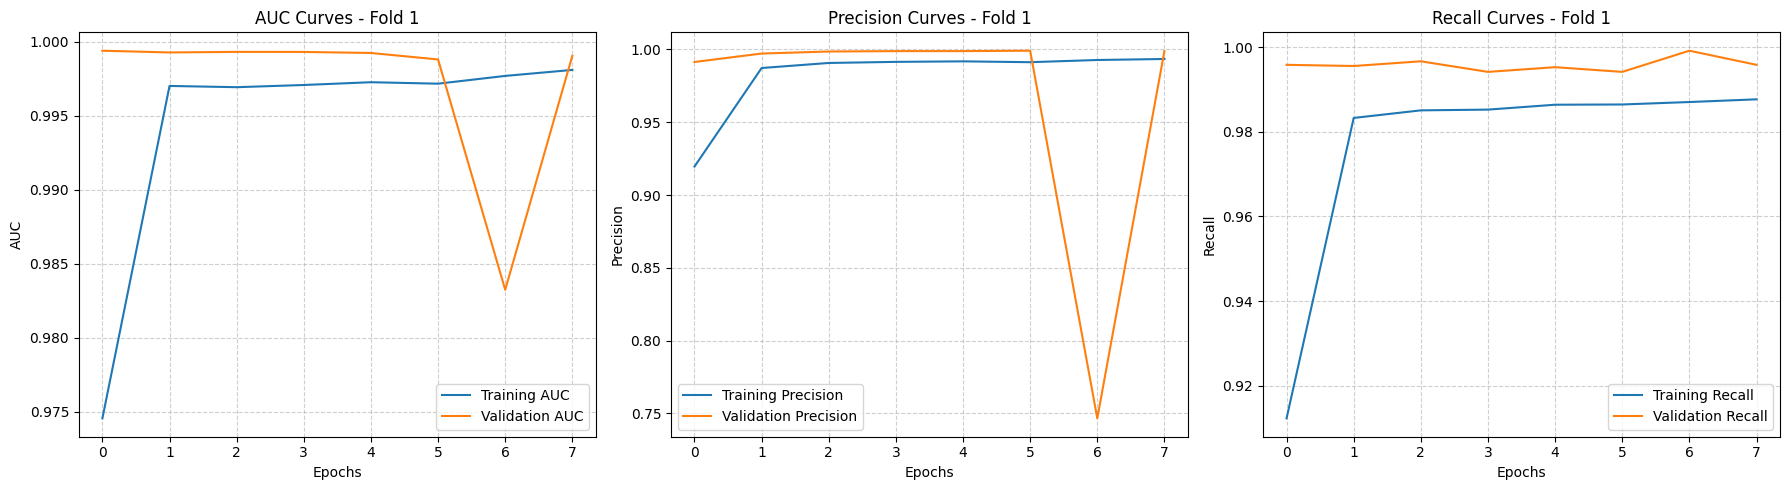

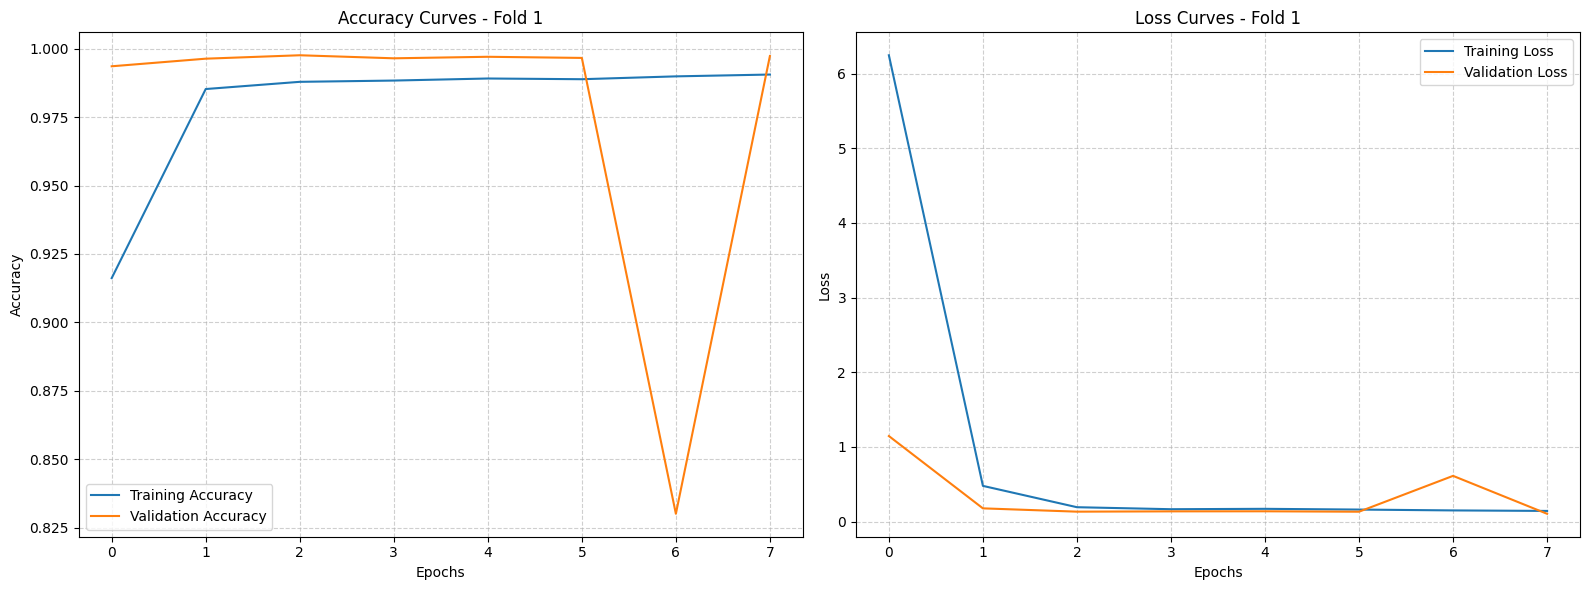


Training fold 2/5


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ sequence_input            │ (None, 300)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_layer           │ (None, 300, 300)       │      4,500,000 │ sequence_input[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_dropout         │ (None, 300, 300)       │              0 │ embedding_layer[0][0]  │
│ (Dropout)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_branch1 (Conv1D)    │ (None, 300, 64)        │         96,064 │ embedding_dropout[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_branch2 (Conv1D)    │ (None, 300, 64)        │         57,664 │ embedding_dropout[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn1_branch1               │ (None, 300, 64)        │            256 │ conv1_branch1[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn1_branch2               │ (None, 300, 64)        │            256 │ conv1_branch2[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ maxpool_branch1           │ (None, 75, 64)         │              0 │ bn1_branch1[0][0]      │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ maxpool_branch2           │ (None, 75, 64)         │              0 │ bn1_branch2[0][0]      │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenation_layer       │ (None, 75, 128)        │              0 │ maxpool_branch1[0][0], │
│ (Concatenate)             │                        │                │ maxpool_branch2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_after_concat      │ (None, 75, 128)        │              0 │ concatenation_layer[0… │
│ (Dropout)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bi_lstm_layer             │ (None, 75, 128)        │         98,816 │ dropout_after_concat[… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 75, 128)        │         33,088 │ bi_lstm_layer[0][0],   │
│ (MultiHeadAttention)      │                        │                │ bi_lstm_layer[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_connection (Add) │ (None, 75, 128)        │              0 │ bi_lstm_layer[0][0],   │
│                      

 Total params: 5,013,345 (19.12 MB)

 Trainable params: 512,321 (1.95 MB)

 Non-trainable params: 4,501,024 (17.17 MB)

Epoch 1/20
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8136 - auc_1: 0.8820 - loss: 11.1501 - precision_1: 0.8056 - recall_1: 0.8230
Epoch 1: val_accuracy improved from -inf to 0.99528, saving model to fake_news_model_fold_2.keras
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 223s 191ms/step - accuracy: 0.8137 - auc_1: 0.8821 - loss: 11.1461 - precision_1: 0.8057 - recall_1: 0.8231 - val_accuracy: 0.9953 - val_auc_1: 0.9986 - val_loss: 1.5045 - val_precision_1: 0.9967 - val_recall_1: 0.9939 - learning_rate: 5.0000e-04
Epoch 2/20
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9865 - auc_1: 0.9966 - loss: 0.9370 - precision_1: 0.9885 - recall_1: 0.9844
Epoch 2: val_accuracy improved from 0.99528 to 0.99541, saving model to fake_news_model_fold_2.keras
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 205s 190ms/step - accuracy: 0.9865 - auc_1: 0.9966 - loss: 0.9367 - precision_1: 0.9885 - recall_1: 0.9844 - val_accuracy: 0.9954 - val_auc_1: 0.9972 - val_loss: 0.2261 - val_precision_1: 0.9997 - 

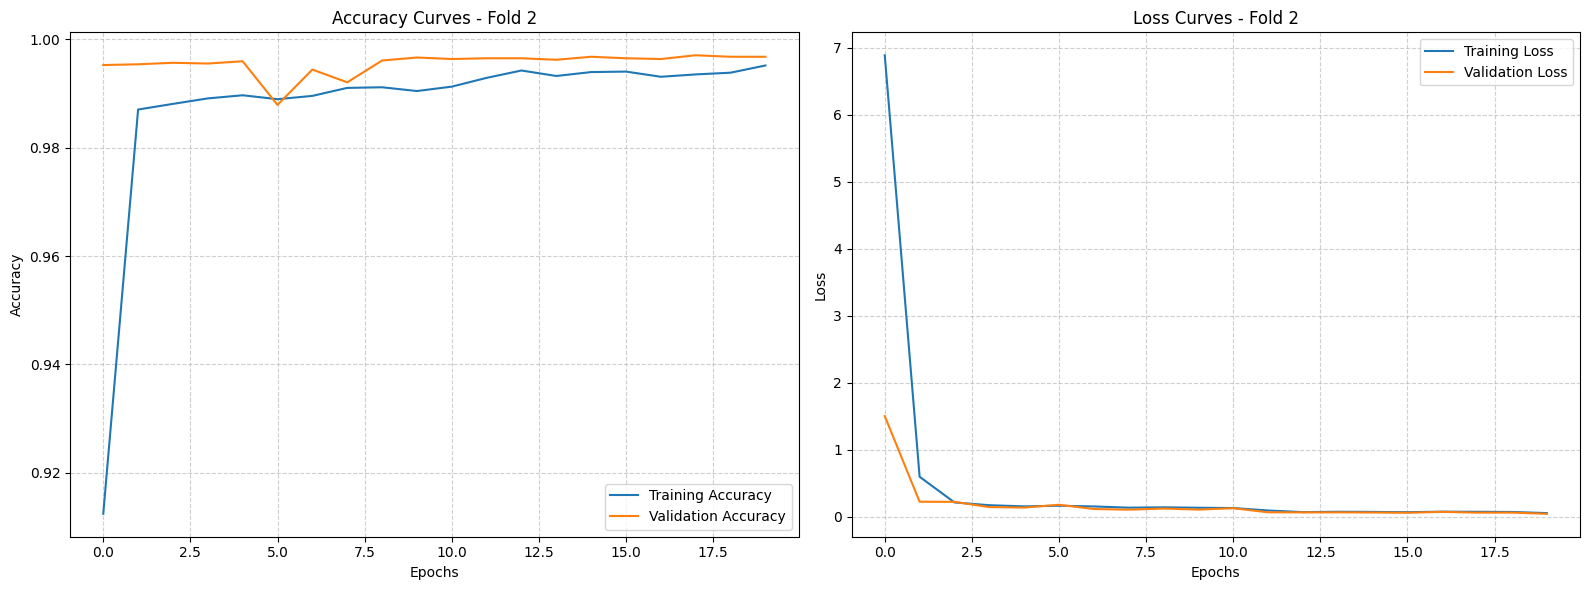


Training fold 3/5


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ sequence_input            │ (None, 300)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_layer           │ (None, 300, 300)       │      4,500,000 │ sequence_input[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_dropout         │ (None, 300, 300)       │              0 │ embedding_layer[0][0]  │
│ (Dropout)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_branch1 (Conv1D)    │ (None, 300, 64)        │         96,064 │ embedding_dropout[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_branch2 (Conv1D)    │ (None, 300, 64)        │         57,664 │ embedding_dropout[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn1_branch1               │ (None, 300, 64)        │            256 │ conv1_branch1[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn1_branch2               │ (None, 300, 64)        │            256 │ conv1_branch2[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ maxpool_branch1           │ (None, 75, 64)         │              0 │ bn1_branch1[0][0]      │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ maxpool_branch2           │ (None, 75, 64)         │              0 │ bn1_branch2[0][0]      │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenation_layer       │ (None, 75, 128)        │              0 │ maxpool_branch1[0][0], │
│ (Concatenate)             │                        │                │ maxpool_branch2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_after_concat      │ (None, 75, 128)        │              0 │ concatenation_layer[0… │
│ (Dropout)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bi_lstm_layer             │ (None, 75, 128)        │         98,816 │ dropout_after_concat[… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 75, 128)        │         33,088 │ bi_lstm_layer[0][0],   │
│ (MultiHeadAttention)      │                        │                │ bi_lstm_layer[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_connection (Add) │ (None, 75, 128)        │              0 │ bi_lstm_layer[0][0],   │
│                      

 Total params: 5,013,345 (19.12 MB)

 Trainable params: 512,321 (1.95 MB)

 Non-trainable params: 4,501,024 (17.17 MB)

Epoch 1/20
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8075 - auc_2: 0.8769 - loss: 11.1980 - precision_2: 0.8057 - recall_2: 0.8078
Epoch 1: val_accuracy improved from -inf to 0.99528, saving model to fake_news_model_fold_3.keras
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 226s 193ms/step - accuracy: 0.8076 - auc_2: 0.8769 - loss: 11.1941 - precision_2: 0.8058 - recall_2: 0.8079 - val_accuracy: 0.9953 - val_auc_2: 0.9982 - val_loss: 1.5758 - val_precision_2: 0.9953 - val_recall_2: 0.9953 - learning_rate: 5.0000e-04
Epoch 2/20
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9858 - auc_2: 0.9972 - loss: 0.9757 - precision_2: 0.9873 - recall_2: 0.9841
Epoch 2: val_accuracy improved from 0.99528 to 0.99722, saving model to fake_news_model_fold_3.keras
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 205s 190ms/step - accuracy: 0.9858 - auc_2: 0.9972 - loss: 0.9753 - precision_2: 0.9873 - recall_2: 0.9841 - val_accuracy: 0.9972 - val_auc_2: 0.9987 - val_loss: 0.2164 - val_precision_2: 0.9989 - 

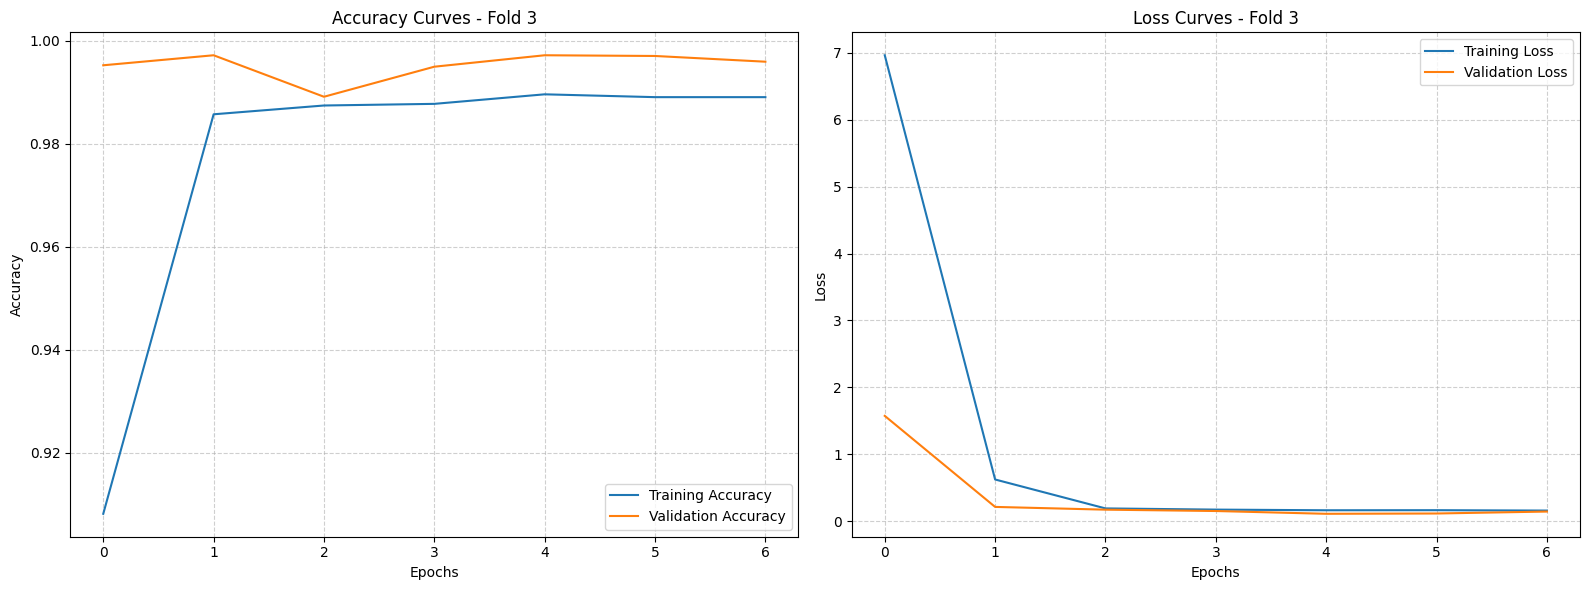


Training fold 4/5


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ sequence_input            │ (None, 300)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_layer           │ (None, 300, 300)       │      4,500,000 │ sequence_input[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_dropout         │ (None, 300, 300)       │              0 │ embedding_layer[0][0]  │
│ (Dropout)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_branch1 (Conv1D)    │ (None, 300, 64)        │         96,064 │ embedding_dropout[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_branch2 (Conv1D)    │ (None, 300, 64)        │         57,664 │ embedding_dropout[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn1_branch1               │ (None, 300, 64)        │            256 │ conv1_branch1[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn1_branch2               │ (None, 300, 64)        │            256 │ conv1_branch2[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ maxpool_branch1           │ (None, 75, 64)         │              0 │ bn1_branch1[0][0]      │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ maxpool_branch2           │ (None, 75, 64)         │              0 │ bn1_branch2[0][0]      │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenation_layer       │ (None, 75, 128)        │              0 │ maxpool_branch1[0][0], │
│ (Concatenate)             │                        │                │ maxpool_branch2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_after_concat      │ (None, 75, 128)        │              0 │ concatenation_layer[0… │
│ (Dropout)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bi_lstm_layer             │ (None, 75, 128)        │         98,816 │ dropout_after_concat[… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 75, 128)        │         33,088 │ bi_lstm_layer[0][0],   │
│ (MultiHeadAttention)      │                        │                │ bi_lstm_layer[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_connection (Add) │ (None, 75, 128)        │              0 │ bi_lstm_layer[0][0],   │
│                      

 Total params: 5,013,345 (19.12 MB)

 Trainable params: 512,321 (1.95 MB)

 Non-trainable params: 4,501,024 (17.17 MB)

Epoch 1/20
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8313 - auc_3: 0.8981 - loss: 10.6042 - precision_3: 0.8218 - recall_3: 0.8474
Epoch 1: val_accuracy improved from -inf to 0.99527, saving model to fake_news_model_fold_4.keras
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 232s 198ms/step - accuracy: 0.8314 - auc_3: 0.8981 - loss: 10.6002 - precision_3: 0.8219 - recall_3: 0.8474 - val_accuracy: 0.9953 - val_auc_3: 0.9990 - val_loss: 1.0973 - val_precision_3: 0.9969 - val_recall_3: 0.9936 - learning_rate: 5.0000e-04
Epoch 2/20
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9868 - auc_3: 0.9967 - loss: 0.6868 - precision_3: 0.9886 - recall_3: 0.9846
Epoch 2: val_accuracy improved from 0.99527 to 0.99708, saving model to fake_news_model_fold_4.keras
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 205s 190ms/step - accuracy: 0.9868 - auc_3: 0.9967 - loss: 0.6866 - precision_3: 0.9886 - recall_3: 0.9846 - val_accuracy: 0.9971 - val_auc_3: 0.9986 - val_loss: 0.1977 - val_precision_3: 0.9997 - 

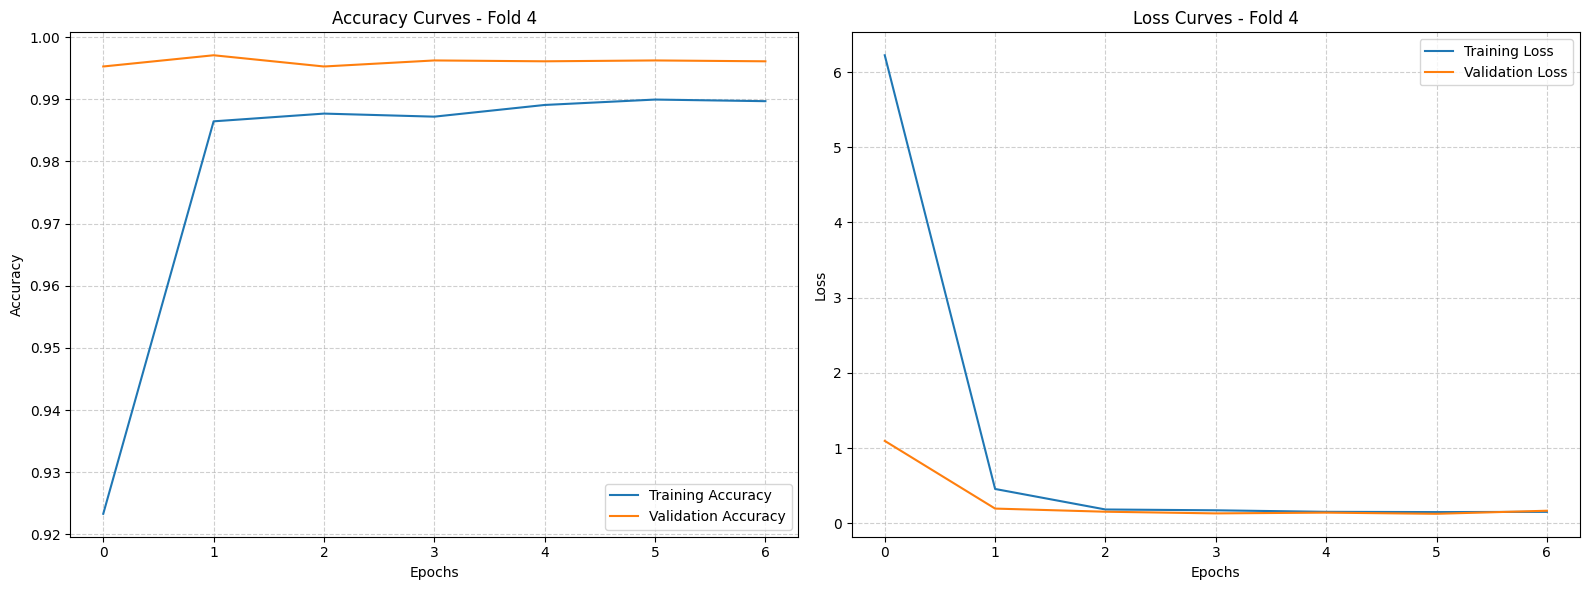


Training fold 5/5


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ sequence_input            │ (None, 300)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_layer           │ (None, 300, 300)       │      4,500,000 │ sequence_input[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_dropout         │ (None, 300, 300)       │              0 │ embedding_layer[0][0]  │
│ (Dropout)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_branch1 (Conv1D)    │ (None, 300, 64)        │         96,064 │ embedding_dropout[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_branch2 (Conv1D)    │ (None, 300, 64)        │         57,664 │ embedding_dropout[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn1_branch1               │ (None, 300, 64)        │            256 │ conv1_branch1[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn1_branch2               │ (None, 300, 64)        │            256 │ conv1_branch2[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ maxpool_branch1           │ (None, 75, 64)         │              0 │ bn1_branch1[0][0]      │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ maxpool_branch2           │ (None, 75, 64)         │              0 │ bn1_branch2[0][0]      │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenation_layer       │ (None, 75, 128)        │              0 │ maxpool_branch1[0][0], │
│ (Concatenate)             │                        │                │ maxpool_branch2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_after_concat      │ (None, 75, 128)        │              0 │ concatenation_layer[0… │
│ (Dropout)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bi_lstm_layer             │ (None, 75, 128)        │         98,816 │ dropout_after_concat[… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 75, 128)        │         33,088 │ bi_lstm_layer[0][0],   │
│ (MultiHeadAttention)      │                        │                │ bi_lstm_layer[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_connection (Add) │ (None, 75, 128)        │              0 │ bi_lstm_layer[0][0],   │
│                      

 Total params: 5,013,345 (19.12 MB)

 Trainable params: 512,321 (1.95 MB)

 Non-trainable params: 4,501,024 (17.17 MB)

Epoch 1/20
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.8269 - auc_4: 0.8974 - loss: 11.2132 - precision_4: 0.8299 - recall_4: 0.8250
Epoch 1: val_accuracy improved from -inf to 0.99555, saving model to fake_news_model_fold_5.keras
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 225s 192ms/step - accuracy: 0.8270 - auc_4: 0.8975 - loss: 11.2093 - precision_4: 0.8300 - recall_4: 0.8250 - val_accuracy: 0.9956 - val_auc_4: 0.9986 - val_loss: 1.6179 - val_precision_4: 0.9958 - val_recall_4: 0.9953 - learning_rate: 5.0000e-04
Epoch 2/20
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9867 - auc_4: 0.9968 - loss: 1.0082 - precision_4: 0.9895 - recall_4: 0.9839
Epoch 2: val_accuracy did not improve from 0.99555
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 203s 188ms/step - accuracy: 0.9867 - auc_4: 0.9968 - loss: 1.0078 - precision_4: 0.9895 - recall_4: 0.9839 - val_accuracy: 0.9951 - val_auc_4: 0.9987 - val_loss: 0.2276 - val_precision_4: 0.9958 - val_recall_4: 0.9944 - learning_rate: 5.0000e-04
E

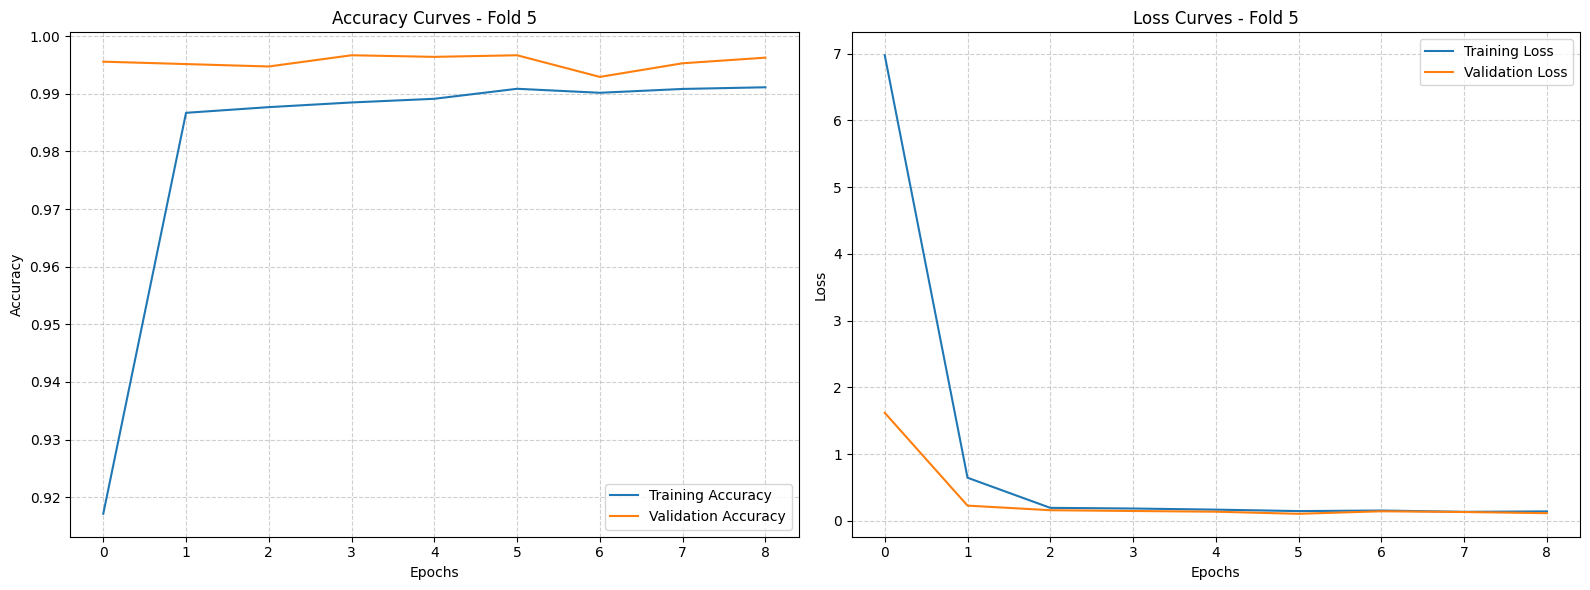

In [15]:
# Implement k-fold cross-validation
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

fold_results = []
best_val_accuracy = 0
best_model = None

for fold, (train_idx, val_idx) in enumerate(skf.split(X_sequences, y)):
    print(f"\nTraining fold {fold+1}/{n_folds}")

    # Split data
    X_train_seq, X_val_seq = X_sequences[train_idx], X_sequences[val_idx]
    X_train_features, X_val_features = X_features[train_idx], X_features[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Build model
    model = build_improved_model(vocab_size, embedding_dim, max_length, X_features.shape[1])

    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.00001,
        verbose=1
    )

    model_checkpoint = ModelCheckpoint(
        f'fake_news_model_fold_{fold+1}.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )

    # Data augmentation function
    def text_augmentation(sequences, labels, augment_ratio=0.2):
        augmented_sequences = sequences.copy()
        augmented_labels = labels.copy()

        # Only augment a portion of the data
        aug_indices = np.random.choice(
            range(len(sequences)),
            size=int(augment_ratio * len(sequences)),
            replace=False
        )

        for idx in aug_indices:
            seq = sequences[idx].copy()
            # Randomly drop words (set to 0)
            drop_indices = np.random.choice(
                range(len(seq)),
                size=int(0.1 * len(seq)),
                replace=False
            )
            for drop_idx in drop_indices:
                if seq[drop_idx] != 0:  # Don't modify padding
                    seq[drop_idx] = 0

            augmented_sequences = np.vstack([augmented_sequences, [seq]])
            augmented_labels = np.append(augmented_labels, labels[idx])

        return augmented_sequences, augmented_labels

    # Apply data augmentation
    X_train_seq_aug, y_train_aug = text_augmentation(X_train_seq, y_train)
    model.summary()
    # Train the model
    history = model.fit(
        [X_train_seq_aug, np.repeat(X_train_features, len(X_train_seq_aug) // len(X_train_features) + 1, axis=0)[:len(X_train_seq_aug)]],
        y_train_aug,
        batch_size=32,  # Smaller batch size
        epochs=20,
        validation_data=([X_val_seq, X_val_features], y_val),
        callbacks=[early_stopping, reduce_lr, model_checkpoint],
        verbose=1
    )

    # Evaluate the model
    val_loss, val_accuracy, val_auc, val_precision, val_recall = model.evaluate(
        [X_val_seq, X_val_features], y_val, verbose=1
    )

    fold_results.append({
        'fold': fold+1,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy,
        'val_auc': val_auc,
        'val_precision': val_precision,
        'val_recall': val_recall
    })

    plot_additional_metrics(history,fold+1)
    visualize_training_history(history,fold+1)
    # Save best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = model


225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - accuracy: 0.9980 - auc: 0.9992 - loss: 0.1320 - precision: 0.9996 - recall: 0.9965
Test Loss: 0.1354
Test Accuracy: 0.9968
Test AUC: 0.9993
Test Precision: 0.9983
Test Recall: 0.9953
225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step


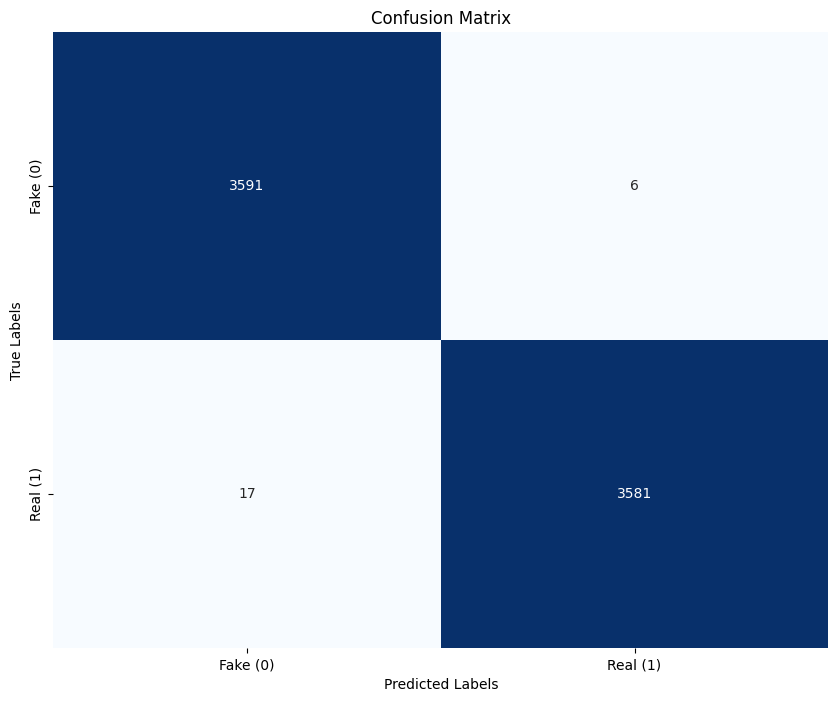

              precision    recall  f1-score   support

   Fake News       1.00      1.00      1.00      3597
   Real News       1.00      1.00      1.00      3598

    accuracy                           1.00      7195
   macro avg       1.00      1.00      1.00      7195
weighted avg       1.00      1.00      1.00      7195



In [16]:
# Assuming you have a test set
visualize_best_model(best_model, X_val_seq, X_val_features, y_val)

In [17]:
# Print cross-validation results
print("\nCross-validation results:")
for result in fold_results:
    print(f"Fold {result['fold']}: Accuracy={result['val_accuracy']:.4f}, AUC={result['val_auc']:.4f}")

# Calculate average performance
avg_accuracy = np.mean([result['val_accuracy'] for result in fold_results])
avg_auc = np.mean([result['val_auc'] for result in fold_results])
print(f"\nAverage Accuracy: {avg_accuracy:.4f}")
print(f"Average AUC: {avg_auc:.4f}")

# Save the best model, tokenizer, and vectorizers
best_model.save('best_fake_news_detection_model.keras')

with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('tfidf_vectorizer.pkl', 'wb') as handle:
    pickle.dump(tfidf_vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("\nBest model, tokenizer, and vectorizers saved successfully!")



Cross-validation results:
Fold 1: Accuracy=0.9976, AUC=0.9993
Fold 2: Accuracy=0.9971, AUC=0.9995
Fold 3: Accuracy=0.9972, AUC=0.9987
Fold 4: Accuracy=0.9971, AUC=0.9986
Fold 5: Accuracy=0.9967, AUC=0.9994

Average Accuracy: 0.9971
Average AUC: 0.9991

Best model, tokenizer, and vectorizers saved successfully!


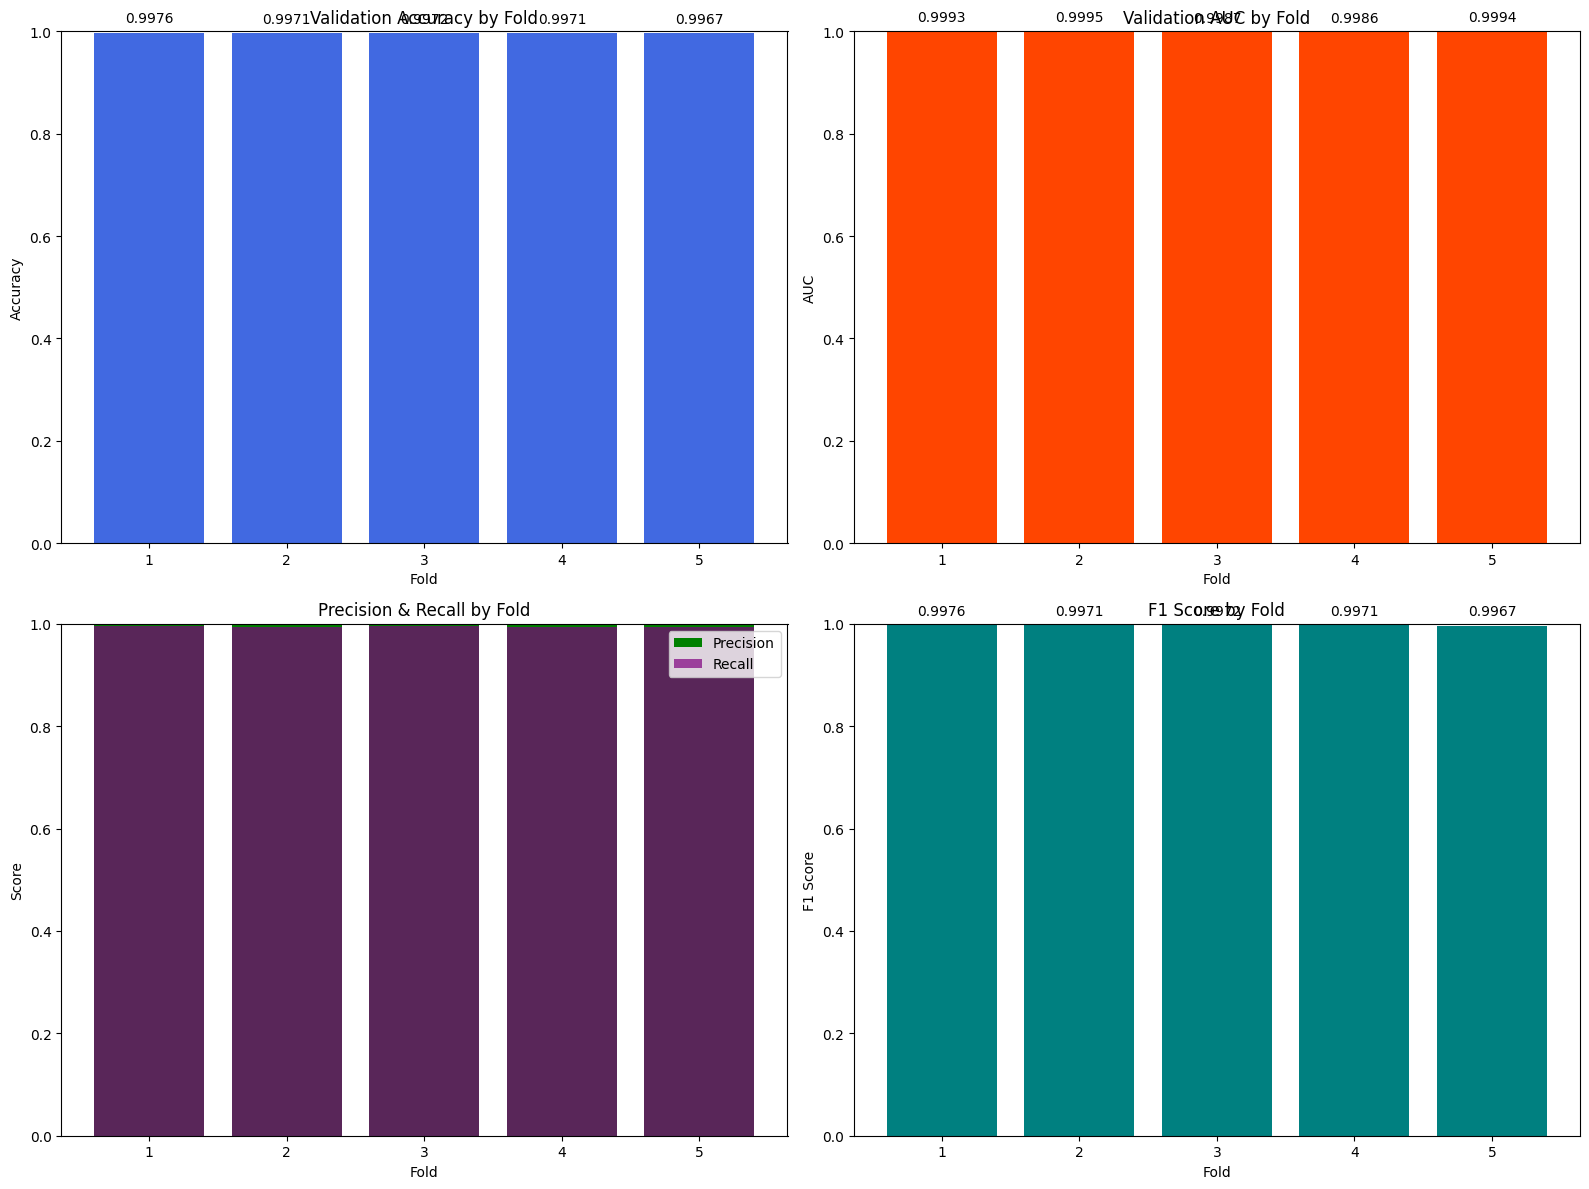


Cross-Validation Summary:
Average Accuracy: 0.9971 ± 0.0003
Average AUC: 0.9991 ± 0.0004
Average Precision: 0.9993 ± 0.0005
Average Recall: 0.9950 ± 0.0010
Average F1 Score: 0.9971 ± 0.0003


In [18]:
visualize_fold_results(fold_results)

In [19]:
# Create inference function for testing on new data
def predict_fake_news(text, model, tokenizer, tfidf_vectorizer):
    # Clean and process text
    cleaned_text = clean_text(text)
    processed_text = tokenize_and_remove_stopwords(cleaned_text)

    # Extract features
    features = extract_features(cleaned_text)
    features_array = np.array([[
        features['sentiment_pos'],
        features['sentiment_neg'],
        features['sentiment_neu'],
        features['sentiment_compound'],
        features['readability'],
        features['grade_level'],
        features['word_count'],
        features['avg_word_length'],
        features['special_char_ratio']
    ]])

    # Tokenize and pad
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')

    # TF-IDF features
    tfidf_features = tfidf_vectorizer.transform([processed_text]).toarray()

    # Combine features
    combined_features = np.hstack((tfidf_features, features_array))

    # Predict
    prediction = model.predict([padded_sequence, combined_features])[0][0]
    label = "Real" if prediction >= 0.5 else "Fake"
    confidence = prediction if prediction >= 0.5 else 1 - prediction

    return {
        'label': label,
        'confidence': float(confidence),
        'raw_score': float(prediction)
    }

In [20]:

# Test function with sample text
sample_text = "srikar meet osamabinladin"
prediction = predict_fake_news(sample_text, best_model, tokenizer, tfidf_vectorizer)
print(f"\nSample prediction: {prediction}")

print("\nModel is ready for inference on real-time data!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Sample prediction: {'label': 'Fake', 'confidence': 0.9786299597471952, 'raw_score': 0.021370040252804756}

Model is ready for inference on real-time data!


In [21]:
import numpy as np
import pandas as pd
import pickle
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import textstat
import os

# Ensure NLTK resources are downloaded
nltk.download('punkt', quiet=True)
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('vader_lexicon',quiet=True)
nltk.download('punkt_tab',quiet=True)

# Load the saved model and preprocessing tools
def load_resources(model_path, tokenizer_path, vectorizer_path):
    """Load the saved model, tokenizer and TF-IDF vectorizer"""

    # Load the model
    model = load_model(model_path)

    # Load the tokenizer
    with open(tokenizer_path, 'rb') as handle:
        tokenizer = pickle.load(handle)

    # Load the TF-IDF vectorizer
    with open(vectorizer_path, 'rb') as handle:
        tfidf_vectorizer = pickle.load(handle)

    return model, tokenizer, tfidf_vectorizer

# Text preprocessing functions
def clean_text(text):
    """Clean and normalize text"""
    if pd.isna(text):
        return ""
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', ' URL ', text, flags=re.MULTILINE)
    # Replace numbers with 'NUM'
    text = re.sub(r'\d+', ' NUM ', text)
    # Remove special characters but keep punctuation for sentiment analysis
    text = re.sub(r'[^\w\s.,!?]', ' ', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenize_and_remove_stopwords(text):
    """Tokenize text and remove stopwords while keeping important words"""
    tokens = word_tokenize(text)
    # Get stopwords but keep important words that might be relevant for fake news detection
    stop_words = set(stopwords.words('english'))
    important_words = {'not', 'no', 'nor', 'but', 'however', 'although', 'though'}
    filtered_stop_words = stop_words - important_words
    tokens = [word for word in tokens if word not in filtered_stop_words]
    return ' '.join(tokens)

def extract_features(text):
    """Extract additional features from text for model input"""
    # Initialize sentiment analyzer
    sia = SentimentIntensityAnalyzer()

    # Sentiment features
    sentiment = sia.polarity_scores(text)

    # Readability features
    readability = textstat.flesch_reading_ease(text)
    grade_level = textstat.flesch_kincaid_grade(text)

    # Text statistics
    word_count = len(text.split())
    avg_word_length = sum(len(word) for word in text.split()) / max(1, word_count)

    # Special character ratio
    special_char_count = len(re.findall(r'[.,!?;:]', text))
    special_char_ratio = special_char_count / max(1, len(text))

    # Create feature dictionary
    features = {
        'sentiment_pos': sentiment['pos'],
        'sentiment_neg': sentiment['neg'],
        'sentiment_neu': sentiment['neu'],
        'sentiment_compound': sentiment['compound'],
        'readability': readability,
        'grade_level': grade_level,
        'word_count': word_count,
        'avg_word_length': avg_word_length,
        'special_char_ratio': special_char_ratio
    }

    return features

# Prediction function
def predict_fake_news(title, text, model, tokenizer, tfidf_vectorizer, max_length=300):
    """
    Predict if a news article is fake or real

    Parameters:
    title (str): The title of the news article
    text (str): The text content of the news article
    model: The loaded Keras model
    tokenizer: The loaded tokenizer
    tfidf_vectorizer: The loaded TF-IDF vectorizer
    max_length (int): Maximum sequence length used during training

    Returns:
    float: Probability of the article being real (0 = fake, 1 = real)
    str: Classification label
    dict: Additional information about the prediction
    """
    # Combine title and text
    content = f"{title} [SEP] {text}"

    # Clean the text
    cleaned_content = clean_text(content)

    # Tokenize and remove stopwords
    processed_content = tokenize_and_remove_stopwords(cleaned_content)

    # Extract features for the model
    features = extract_features(cleaned_content)
    features_df = pd.DataFrame([features])

    # Create sequence input
    sequences = tokenizer.texts_to_sequences([processed_content])
    X_seq = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

    # Create TF-IDF features
    X_tfidf = tfidf_vectorizer.transform([processed_content]).toarray()

    # Combine all features
    X_features = np.hstack((X_tfidf, features_df.values))

    # Make prediction
    prediction = model.predict([X_seq, X_features])[0][0]

    # Determine classification and confidence
    label = "REAL" if prediction >= 0.5 else "FAKE"
    confidence = prediction if prediction >= 0.5 else 1 - prediction

    # Prepare additional info
    sentiment_score = features['sentiment_compound']
    sentiment_label = "Positive" if sentiment_score > 0.05 else "Negative" if sentiment_score < -0.05 else "Neutral"

    info = {
        'prediction_probability': float(prediction),
        'confidence': float(confidence),
        'sentiment': sentiment_label,
        'sentiment_score': sentiment_score,
        'readability_score': features['readability'],
        'grade_level': features['grade_level'],
    }

    return prediction, label, info

# Function to print detailed prediction results
def print_prediction_results(title, prediction, label, info):
    """Print detailed prediction results"""
    print("\n" + "="*50)
    print(f"TITLE: {title}")
    print("="*50)
    print(f"\nPREDICTION: {label} NEWS")
    print(f"Confidence: {info['confidence']*100:.2f}%")
    print(f"\nAdditional Information:")
    print(f"- Raw prediction score: {info['prediction_probability']:.4f}")
    print(f"- Sentiment: {info['sentiment']} ({info['sentiment_score']:.2f})")
    print(f"- Readability: {info['readability_score']:.1f} (Flesch Reading Ease)")
    print(f"- Grade Level: {info['grade_level']:.1f} (Flesch-Kincaid)")
    print("="*50)



In [22]:

# Define file paths for model and resources

# model_path = r'C:\Users\AI-Team\Downloads\fake_news\best_fake_news_detection_model.keras'
# tokenizer_path = r'C:\Users\AI-Team\Downloads\fake_news\tokenizer.pkl'
# vectorizer_path = r'C:\Users\AI-Team\Downloads\fake_news\tfidf_vectorizer.pkl'

model_path = '/kaggle/working/best_fake_news_detection_model.keras'
tokenizer_path = '/kaggle/working/tokenizer.pkl'
vectorizer_path = '/kaggle/working/tfidf_vectorizer.pkl'

# Load the model and preprocessing tools
print("Loading model and resources...")
try:
    model, tokenizer, tfidf_vectorizer = load_resources(model_path, tokenizer_path, vectorizer_path)
    print("Model and resources loaded successfully!")
except Exception as e:
    print(f"Error loading resources: {str(e)}")


# Interactive loop for user input
print("\n" + "="*50)
print("FAKE NEWS DETECTION SYSTEM")
print("="*50)
print("\nEnter news articles to analyze. Type 'exit' to quit.")





Loading model and resources...
Model and resources loaded successfully!

FAKE NEWS DETECTION SYSTEM

Enter news articles to analyze. Type 'exit' to quit.


In [23]:
title = "Scientists discover new renewable energy source"
text = "Researchers at MIT have announced a breakthrough in renewable energy technology. The new method harnesses ambient thermal energy with twice the efficiency of current solar panels. The research team published their findings in Nature Energy after three years of laboratory testing. Industry experts call this discovery a potential game-changer for clean energy production. The technology could be commercially viable within five years, according to lead researcher Dr. Sarah Chen."
# Make prediction
print("\nAnalyzing article...")
try:
    prediction, label, info = predict_fake_news(
        title,
        text,
        model,
        tokenizer,
        tfidf_vectorizer
    )

    print_prediction_results(title, prediction, label, info)
except Exception as e:
    print(f"\nError analyzing article: {str(e)}")


Analyzing article...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

TITLE: Scientists discover new renewable energy source

PREDICTION: FAKE NEWS
Confidence: 91.63%

Additional Information:
- Raw prediction score: 0.0837
- Sentiment: Positive (0.91)
- Readability: 22.0 (Flesch Reading Ease)
- Grade Level: 14.0 (Flesch-Kincaid)


In [24]:
title = "'As U.S. budget fight looms, Republicans flip their fiscal script","WASHINGTON (Reuters)"
text = "the head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support education, scientific research, infrastructure, public health and environmental protection. “The (Trump) administration has already been willing to say: ‘We’re going to increase non-defense discretionary spending ... by about 7 percent,’” Meadows, chairman of the small but influential House Freedom Caucus, said on the program. “Now, Democrats are saying that’s not enough, we need to give the government a pay raise of 10 to 11 percent. For a fiscal conservative, I don’t see where the rationale is. ... Eventually you run out of other people’s money,” he said. Meadows was among Republicans who voted in late December for their party’s debt-financed tax overhaul, which is expected to balloon the federal budget deficit and add about $1.5 trillion over 10 years to the $20 trillion national debt. “It’s interesting to hear Mark talk about fiscal responsibility,” Democratic U.S. Representative Joseph Crowley said on CBS. Crowley said the Republican tax bill would require the  United States to borrow $1.5 trillion, to be paid off by future generations, to finance tax cuts for corporations and the rich. “This is one of the least ... fiscally responsible bills we’ve ever seen passed in the history of the House of Representatives. I think we’re going to be paying for this for many, many years to come,” Crowley said. Republicans insist the tax package, the biggest U.S. tax overhaul in more than 30 years,  will boost the economy and job growth. House Speaker Paul Ryan, who also supported the tax bill, recently went further than Meadows, making clear in a radio interview that welfare or “entitlement reform,” as the party often calls it, would be a top Republican priority in 2018. In Republican parlance, “entitlement” programs mean food stamps, housing assistance, Medicare and Medicaid health insurance for the elderly, poor and disabled, as well as other programs created by Washington to assist the needy. Democrats seized on Ryan’s early December remarks, saying they showed Republicans would try to pay for their tax overhaul by seeking spending cuts for social programs. But the goals of House Republicans may have to take a back seat to the Senate, where the votes of some Democrats will be needed to approve a budget and prevent a government shutdown. Democrats will use their leverage in the Senate, which Republicans narrowly control, to defend both discretionary non-defense programs and social spending, while tackling the issue of the “Dreamers,” people brought illegally to the country as children. Trump in September put a March 2018 expiration date on the Deferred Action for Childhood Arrivals, or DACA, program, which protects the young immigrants from deportation and provides them with work permits. The president has said in recent Twitter messages he wants funding for his proposed Mexican border wall and other immigration law changes in exchange for agreeing to help the Dreamers. Representative Debbie Dingell told CBS she did not favor linking that issue to other policy objectives, such as wall funding. “We need to do DACA clean,” she said.  On Wednesday, Trump aides will meet with congressional leaders to discuss those issues. That will be followed by a weekend of strategy sessions for Trump and Republican leaders on Jan. 6 and 7, the White House said. Trump was also scheduled to meet on Sunday with Florida Republican Governor Rick Scott, who wants more emergency aid. The House has passed an $81 billion aid package after hurricanes in Florida, Texas and Puerto Rico, and wildfires in California. The package far exceeded the $44 billion requested by the Trump administration. The Senate has not yet voted on the aid. "
# Make prediction
print("\nAnalyzing article...")
try:
    prediction, label, info = predict_fake_news(
        title,
        text,
        model,
        tokenizer,
        tfidf_vectorizer
    )

    print_prediction_results(title, prediction, label, info)
except Exception as e:
    print(f"\nError analyzing article: {str(e)}")


Analyzing article...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

TITLE: ("'As U.S. budget fight looms, Republicans flip their fiscal script", 'WASHINGTON (Reuters)')

PREDICTION: REAL NEWS
Confidence: 99.90%

Additional Information:
- Raw prediction score: 0.9990
- Sentiment: Positive (0.99)
- Readability: 50.9 (Flesch Reading Ease)
- Grade Level: 11.2 (Flesch-Kincaid)


In [25]:
title = "'NYC Terrorist Ahmad Rahami Sued Police Department for ‘Religious Persecution’ in 2011! ⋆ Freedom Daily"
text = """196 SHARES Facebook Twitter

For a little over a decade today’s millennials have been described as being part of the “everyone gets a trophy generation.” Effort and standards are a thing of the past, so much so that even the standard to be a victim is at historic lows.

Would you believe that the man behind Saturday’s NJ and NYC bombings once claimed to be a victim of “Islamophobia?” This was allegedly such a problem that the attacker Ahmad Khan Rahami and his father once sued the police in Elizabeth New Jersey for discrimination, and also accused other members of the community of discrimination based on religion.

The journalists over at the Daily Mail did some digging into the lawsuit, and here’s what they found (courtesy of Louder With Crowder):

The prime suspect in the New York and New Jersey bombings sued his local police force and claimed they were persecuting him for being a Muslim. Ahmad Rahami said in a lawsuit that cops in Elizabeth, New Jersey subjected his and his family to discrimination and ‘selective enforcement’ based on their religion. The family claimed that police tried to shut down their chicken restaurant, called First American, too early each night with ‘baseless’ tickets and summonses. Ahmad, 28, his father Mohammad Sr, 53, and his brother Mohammad, brought the lawsuit together and said that local residents also racially abused them and said: ‘Muslims don’t belong here’. The lawsuit was filed in 2011 and reveals that Ahmad has a long history of grievances with city officials, their local police force and people who lived close to them.

No, you’re not living in an episode of the Twilight Zone right now, this is real life.

Mayor Christian Bollwage insisted to The New York Times that there was no such discrimination. “It was neighbor complaints, it had nothing to do his with ethnicity or religion,” Bollwage said, adding, “It had to do with noise and people congregating on the streets.”

Rahami’s family owns a fried chicken restaurant in Elizabeth, NJ called First American Fried Chicken. This is also the same town where five bombs were found at a train station Monday morning. His lawsuit went nowhere, so apparently his strategy in that particular case was that if you can’t beat them in the courts: bomb them instead.

Welcome to Obama’s America – where even an Islamic terrorist can play the victim!

How insane is this? Get the word out – share this post on Facebook and Twitter."""
# Make prediction
print("\nAnalyzing article...")
try:
    prediction, label, info = predict_fake_news(
        title,
        text,
        model,
        tokenizer,
        tfidf_vectorizer
    )

    print_prediction_results(title, prediction, label, info)
except Exception as e:
    print(f"\nError analyzing article: {str(e)}")


Analyzing article...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

TITLE: 'NYC Terrorist Ahmad Rahami Sued Police Department for ‘Religious Persecution’ in 2011! ⋆ Freedom Daily

PREDICTION: FAKE NEWS
Confidence: 99.65%

Additional Information:
- Raw prediction score: 0.0035
- Sentiment: Negative (-0.99)
- Readability: 48.2 (Flesch Reading Ease)
- Grade Level: 12.2 (Flesch-Kincaid)


In [26]:
title = " Pence gives no specifics on why Trump Foundation story is inaccurate"
text = """Pence gives no specifics on why Trump Foundation story is inaccurate

When it comes to the Trump campaign's allegations of "inaccuracies and omissions" against a Washington Post story, running mate Mike Pence struggled late Tuesday night to account for specific examples.

Appearing on MSNBC's "The 11th Hour with Brian Williams" after an evening rally in Williamsburg, Virginia, the Indiana governor backed up the Trump campaign's statement against the Post's reporting earlier in the day that Donald Trump spent $258,000 from his charitable foundation to settle legal issues.

Story Continued Below

"Well, I think what we found is that there is a number of factual errors in that story as there were in previous stories about the Trump Foundation. I'm confident they'll be able to address those and demonstrate that they fully complied with the law," Pence told Brian Williams, adding that the "larger issue" is the Clinton Foundation.

Williams tried to button up the issue, pressing Pence specifically for "what the factual errors are that the campaign is alleging" from the latest Post story.

"Well, I think the foundation will be able to lay those out. There were errors in the previous Washington Post stories, and, you know, look, you know me a while, Brian. I strongly support a free and independent press. People are entitled to ask questions, and I'm sure the Trump Foundation and the Trump family will continue to be able to answer those questions."

Pence's comments and the Trump campaign statement came hours after the latest article from the Post into the Republican nominee's charitable foundation.
"""
# Make prediction
print("\nAnalyzing article...")
try:
    prediction, label, info = predict_fake_news(
        title,
        text,
        model,
        tokenizer,
        tfidf_vectorizer
    )

    print_prediction_results(title, prediction, label, info)
except Exception as e:
    print(f"\nError analyzing article: {str(e)}")


Analyzing article...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

TITLE:  Pence gives no specifics on why Trump Foundation story is inaccurate

PREDICTION: FAKE NEWS
Confidence: 98.32%

Additional Information:
- Raw prediction score: 0.0168
- Sentiment: Positive (0.90)
- Readability: 42.8 (Flesch Reading Ease)
- Grade Level: 14.3 (Flesch-Kincaid)


In [27]:
title = " Why is it “RACIST” to Question Someone’s Birth Certificate? – Eagle Rising"
text = """The Democrats are using an intimidation tactic which they are prone to use incessantly. If you question the veracity of a black president’s birth certificate you are racist. That is the outright claim of Lynn Sweet Washington Bureau Chief for the Chicago Sun-Times made on Fox News. Consider the slanted claim that if a president is black and his birth certificate is called into question the conclusion is you must be a racist. What is wrong with this obvious non-sequitur?

First of all, there is evidence the birth certificate presented was altered. This is discounted by the claims that whoever presented this must be racist. Secondly, the social security number presented of Barack Obama was issued in Connecticut where there is no record of him domiciling there. Third, the hospital that issued his birth certificate in Hawaii didn’t exist when it was “issued.” Fourth, an examination of the birth certificate produced several errors that could only be attributed to falsification. Has an unquestioned birth certificate ever been presented? No, only a cry of racism when the request is made. They can’t produce an original document and they then rely on the smear of “birther” and racism to substantiate that which they can produce no physical evidence of. Sadly, Donald Trump has bowed to their…

The views expressed in this opinion article are solely those of their author and are not necessarily either shared or endorsed by EagleRising.com"""
# Make prediction
print("\nAnalyzing article...")
try:
    prediction, label, info = predict_fake_news(
        title,
        text,
        model,
        tokenizer,
        tfidf_vectorizer
    )

    print_prediction_results(title, prediction, label, info)
except Exception as e:
    print(f"\nError analyzing article: {str(e)}")


Analyzing article...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

TITLE:  Why is it “RACIST” to Question Someone’s Birth Certificate? – Eagle Rising

PREDICTION: FAKE NEWS
Confidence: 99.07%

Additional Information:
- Raw prediction score: 0.0093
- Sentiment: Negative (-0.99)
- Readability: 54.2 (Flesch Reading Ease)
- Grade Level: 9.9 (Flesch-Kincaid)


In [28]:
title = " US: ISIS did not use mustard agent in base attack"
text = """Story highlights A final lab test of ISIS weapon fired on US troops tested negative for mustard agent

US forces were fired on last week by ISIS, initial tests showed a chemical weapon was used

Washington (CNN) The American-led military coalition against ISIS said Tuesday that a final laboratory test of the weapon ISIS fired at a US-Iraqi base in northern Iraq last week did not contain a mustard agent as earlier believed.
...
Military officials had told CNN that a second test of the weapon had produced negative results while a third lab test was inconclusive. The most recent test announced by Dorrian represents the final test of the weapon.

"""
# Make prediction
print("\nAnalyzing article...")
try:
    prediction, label, info = predict_fake_news(
        title,
        text,
        model,
        tokenizer,
        tfidf_vectorizer
    )

    print_prediction_results(title, prediction, label, info)
except Exception as e:
    print(f"\nError analyzing article: {str(e)}")


Analyzing article...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

TITLE:  US: ISIS did not use mustard agent in base attack

PREDICTION: REAL NEWS
Confidence: 78.17%

Additional Information:
- Raw prediction score: 0.7817
- Sentiment: Negative (-0.98)
- Readability: 21.4 (Flesch Reading Ease)
- Grade Level: 20.5 (Flesch-Kincaid)
